## Project Title: Climate Change Impact Visualization Using Global Temperature Data
### Group Members:
1. Sarthak Bharatkumar Patel
2. Jay Amrutbhai Patel

### Importing required libraries.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

### Dataset

For this project, we have selected a dataset from Berkeley Earth, a detailed compilation affiliated with the Lawrence Berkeley National Laboratory. The Berkeley Earth Surface Temperature Study is a robust dataset that combines 1.6 billion temperature reports from 16 pre-existing archives. This dataset has been meticulously prepared to ensure accuracy, despite the inherent complexities and variations in data collection methods over the past century.

The Berkeley Earth dataset includes temperature records from a variety of sources, including early mercury thermometer readings, data from weather stations moved due to airport constructions in the 1940s, and readings from electronic thermometers introduced in the 1980s. This extensive dataset allows for detailed analysis and slicing into interesting subsets, such as by country or region, making it an ideal choice for this climate change impact visualization project.

Link: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


In [ ]:
! kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data

Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
License(s): CC-BY-NC-SA-4.0
 93% 79.0M/84.7M [00:01<00:00, 95.7MB/s]
100% 84.7M/84.7M [00:01<00:00, 71.3MB/s]


In [ ]:
! unzip climate-change-earth-surface-temperature-data.zip

Archive:  climate-change-earth-surface-temperature-data.zip
  inflating: GlobalLandTemperaturesByCity.csv  
  inflating: GlobalLandTemperaturesByCountry.csv  
  inflating: GlobalLandTemperaturesByMajorCity.csv  
  inflating: GlobalLandTemperaturesByState.csv  
  inflating: GlobalTemperatures.csv  


The key columns in the dataset are as follows:

**<u>Date</u>**: The starting year for average land temperature is 1750, and for maximum, minimum land temperatures, and global ocean and land temperatures, it is 1850 till 2019.

**<u>LandAverageTemperature</u>**: Global average land temperature recorded in Celsius.

**<u>LandAverageTemperatureUncertainty</u>**: The 95% confidence interval around the global average land temperature.

**<u>LandMaxTemperature</u>**: Global average maximum land temperature in Celsius.

**<u>LandMaxTemperatureUncertainty</u>**: The 95% confidence interval around the global average maximum land temperature.

**<u>LandMinTemperature</u>**: Global average minimum land temperature in Celsius.

**<u>LandMinTemperatureUncertainty</u>**: The 95% confidence interval around the global average minimum land temperature.

**<u>LandAndOceanAverageTemperature</u>**: Global average land and ocean temperature in Celsius.

**<u>LandAndOceanAverageTemperatureUncertainty</u>**: The 95% confidence interval around the global average land and ocean temperature.

In [ ]:
df_global = pd.read_csv('GlobalTemperatures.csv')
df_country = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
df_city = pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [ ]:
df_city.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


In [ ]:
df_city.isna().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

### Data Cleaning and Pre-processing.

In [ ]:
# Function to return the month name
def get_month_name(month_number):
    months = {
        1: 'January',
        2: 'February',
        3: 'March',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: 'August',
        9: 'September',
        10: 'October',
        11: 'November',
        12: 'December'
    }
    return months.get(month_number)

# Function to get the latitude co-ordinate removing N and S.
def get_latitude_coordinate(x):
    if x[-1] == 'N' :
        return float(x[:-1])
    elif x[-1] == 'S' :
        return float("-" + x[:-1])
    else :
        return None

# Function to get the longitude co-ordinate removing N and S.
def get_longitude_coordinate(x):
    if x[-1] == 'E':
        return float(x[:-1])
    elif x[-1] == 'W':
        return -float(x[:-1])
    else:
        return None

Removing the null values from each and every dataset.

In [ ]:
df_city.dropna(axis= 0 , subset= ['AverageTemperature'] , inplace= True)
df_country.dropna(axis= 0 , subset=  ['AverageTemperature'] , inplace= True)

Fetching month and year column differently

In [ ]:
df_global['Year'] = pd.to_datetime(df_global['dt']).dt.year
df_city['Year'] = pd.to_datetime(df_city['dt']).dt.year
df_country['Year'] = pd.to_datetime(df_country['dt']).dt.year

In [ ]:
df_global['Month_Name'] = pd.to_datetime(df_global['dt']).dt.month.apply(get_month_name)
df_city['Month_Name'] = pd.to_datetime(df_city['dt']).dt.month.apply(get_month_name)
df_country['Month_Name'] = pd.to_datetime(df_country['dt']).dt.month.apply(get_month_name)

Separating ocean average from their sum with the land average.

In [ ]:
df_global['OceanAverageTemperature'] = df_global['LandAndOceanAverageTemperature'] - df_global['LandAverageTemperature']

In [ ]:
df_city['Lat_Cor'] = df_city['Latitude'].apply(get_latitude_coordinate)
df_city['Lon_Cor'] = df_city['Longitude'].apply(get_longitude_coordinate)

Making the data from 1912 to 2012.

In [ ]:
df_country = df_country[df_country['Year'] >= 1912]
df_city = df_city[df_city['Year'] >= 1912]
df_global = df_global[df_global['Year'] >= 1912]

df_country = df_country[df_country['Year'] <= 2012]
df_city = df_city[df_city['Year'] <= 2012]
df_global = df_global[df_global['Year'] <= 2012]

### Data Visualization

Calculate global yearly average temperatures to show difference getting higher between land and ocean average temperature.

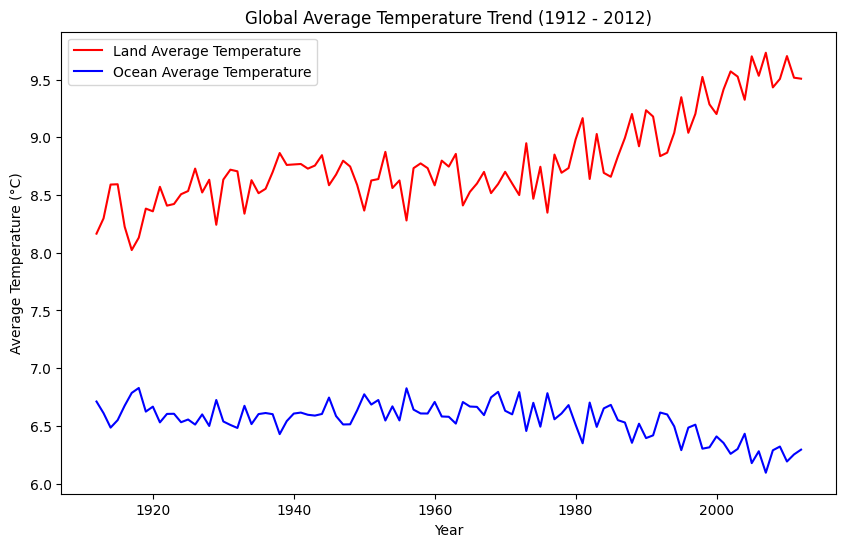

In [ ]:

global_yearly_avg_temp = df_global.groupby('Year')[['LandAverageTemperature', 'OceanAverageTemperature']].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(global_yearly_avg_temp['Year'], global_yearly_avg_temp['LandAverageTemperature'], color='r')

plt.plot(global_yearly_avg_temp['Year'], global_yearly_avg_temp['OceanAverageTemperature'], color='b')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend(['Land Average Temperature', 'Ocean Average Temperature'])
plt.title('Global Average Temperature Trend (1912 - 2012)')
plt.show()

Visualization for India over the century with every extreme condition.

In [ ]:
! pip install dash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

# Convert date column to datetime format
data['dt'] = pd.to_datetime(data['dt'])

# Filter data from 1900 onwards and for India
data_filtered = data[(data['dt'].dt.year >= 1900) & (data['Country'] == 'India')]

# Drop rows with missing temperature values
data_filtered = data_filtered.dropna(subset=['AverageTemperature'])

# Extract year from date
data_filtered['Year'] = data_filtered['dt'].dt.year

# Calculate yearly average temperatures for India
yearly_avg_temp_india = data_filtered.groupby('Year')['AverageTemperature'].mean().reset_index()

# Calculate Mean and Standard Deviation
mean_temp = yearly_avg_temp_india['AverageTemperature'].mean()
std_dev_temp = yearly_avg_temp_india['AverageTemperature'].std()

yearly_avg_temp_india['Mean'] = mean_temp
yearly_avg_temp_india['Mean + Std Dev'] = mean_temp + std_dev_temp
yearly_avg_temp_india['Mean - Std Dev'] = mean_temp - std_dev_temp

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Temperature Analysis of India with Extreme Weather Conditions"),

    dcc.Graph(id='india-temp-trend')
])

# Update temperature trend graph
@app.callback(
    Output('india-temp-trend', 'figure'),
    [Input('india-temp-trend', 'id')]
)
def update_temp_trend(_):
    fig = go.Figure()

    # Add average temperature line
    fig.add_trace(go.Scatter(x=yearly_avg_temp_india['Year'], y=yearly_avg_temp_india['AverageTemperature'],
                             mode='lines+markers', name='Average Temperature', line=dict(color='blue')))

    # Add mean temperature line
    fig.add_trace(go.Scatter(x=yearly_avg_temp_india['Year'], y=yearly_avg_temp_india['Mean'],
                             mode='lines', name='Mean Temperature', line=dict(color='green', dash='dash')))

    # Add mean + std deviation line
    fig.add_trace(go.Scatter(x=yearly_avg_temp_india['Year'], y=yearly_avg_temp_india['Mean + Std Dev'],
                             mode='lines', name='Mean + Std Dev', line=dict(color='red', dash='dash')))

    # Add mean - std deviation line
    fig.add_trace(go.Scatter(x=yearly_avg_temp_india['Year'], y=yearly_avg_temp_india['Mean - Std Dev'],
                             mode='lines', name='Mean - Std Dev', line=dict(color='red', dash='dash')))

    # Highlight extreme weather conditions
    extreme_above = yearly_avg_temp_india[yearly_avg_temp_india['AverageTemperature'] > yearly_avg_temp_india['Mean + Std Dev']]
    extreme_below = yearly_avg_temp_india[yearly_avg_temp_india['AverageTemperature'] < yearly_avg_temp_india['Mean - Std Dev']]

    fig.add_trace(go.Scatter(x=extreme_above['Year'], y=extreme_above['AverageTemperature'],
                             mode='markers', name='Extreme Above', marker=dict(color='orange', size=10)))

    fig.add_trace(go.Scatter(x=extreme_below['Year'], y=extreme_below['AverageTemperature'],
                             mode='markers', name='Extreme Below', marker=dict(color='purple', size=10)))

    fig.update_layout(title='Average Temperature of India with Extreme Weather Conditions',
                      xaxis_title='Year', yaxis_title='Temperature (°C)')

    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=8050)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 20.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

Geographic analysis for the whole country.

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# Load the dataset
data = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

# Extract year from date
data['dt'] = pd.to_datetime(data['dt'])
data_filtered = data[data['dt'].dt.year >= 1900]
data_filtered['Year'] = data_filtered['dt'].dt.year

# Calculate yearly average temperatures for each country
yearly_avg_temp = data_filtered.groupby(['Country', 'Year'])['AverageTemperature'].mean().reset_index()

# Initialize the Dash app
app1 = dash.Dash(__name__)

app1.layout = html.Div([
    dcc.Graph(id='global-temp-trend'),
    dcc.Slider(
        id='year-slider',
        min=yearly_avg_temp['Year'].min(),
        max=yearly_avg_temp['Year'].max(),
        value=yearly_avg_temp['Year'].max(),
        marks={str(year): str(year) for year in range(yearly_avg_temp['Year'].min(), yearly_avg_temp['Year'].max() + 1, 10)},
        step=1
    )
])

@app1.callback(
    Output('global-temp-trend', 'figure'),
    [Input('year-slider', 'value')]
)
def update_graph(selected_year):
    filtered_data = yearly_avg_temp[yearly_avg_temp['Year'] == selected_year]
    fig = px.choropleth(filtered_data, locations='Country', locationmode='country names',
                        color='AverageTemperature', hover_name='Country',
                        color_continuous_scale=px.colors.sequential.Plasma,
                        title=f'Average Temperature by Country in {selected_year}')
    return fig

if __name__ == '__main__':
    app1.run_server(debug=True, port=8051)


<IPython.core.display.Javascript object>

Vertical box plot for average temperatures of every month.

In [ ]:
fig = px.box(df_global, y='LandAverageTemperature', x='Month_Name', color='Month_Name', orientation='v' )

fig.update_layout( title='Vertical Box Plot of Land Average Temperature by Months :--',height = 600,width = 900,
    xaxis_title='Land Average Temperature', yaxis_title='Century' , title_x = 0.5)

fig.show()

Analysis on increase in temperature over the century for every decade for the whole world.

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

# Load the dataset
data = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

# Convert date column to datetime format
data['dt'] = pd.to_datetime(data['dt'])

# Filter data from 1900 onwards
data_filtered = data[data['dt'].dt.year >= 1900]

# Drop rows with missing temperature values
data_filtered = data_filtered.dropna(subset=['AverageTemperature'])

# Extract year from date
data_filtered['Year'] = data_filtered['dt'].dt.year

# Specify old and new timeframes
old = [1912, 1916]
new = [2008, 2012]

# Define conditions for old and new timeframes
cond_old = (data_filtered['Year'] >= old[0]) & (data_filtered['Year'] <= old[1])
cond_new = (data_filtered['Year'] >= new[0]) & (data_filtered['Year'] <= new[1])

# Assign period labels
data_filtered.loc[cond_old, 'Period'] = 'Old'
data_filtered.loc[cond_new, 'Period'] = 'New'

# Calculate mean temperatures for old and new periods
diff_temp = data_filtered.pivot_table(index='Country', columns='Period', values='AverageTemperature', aggfunc='mean')
diff_temp['Diff'] = diff_temp['New'] - diff_temp['Old']
diff_temp = diff_temp.reset_index().dropna()

# Create the bar plot
fig = px.bar(diff_temp.sort_values('Diff', ascending=True), x='Diff', y='Country',
             title=f'Countries with the Most Increase in Temperature ({new[0]}-{new[1]} vs {old[0]}-{old[1]})',
             labels={'Diff': 'Increase in Temperature (°C)', 'Country': ''},
             color='Diff', color_continuous_scale='Rainbow', orientation='h')

# Adjust the height of the plot
fig.update_layout(xaxis_title='Increase in Temperature (°C)', yaxis_title='',
                  height=4000)  # Adjust height as needed to fit all countries

# Display the figure
fig.show()


### Time Series Analysis

Filtering the dataset for tempe.

In [ ]:
usa=df_city[df_city['Country']=='United States']

city=['Tempe']
df_usa=usa[usa['City'].isin(city)]


df_usa=df_usa[['dt','AverageTemperature']]
df_usa.columns=['Date','AverageTemperature']
df_usa['Date']=pd.to_datetime(df_usa['Date'])
df_usa.set_index('Date',inplace=True)
df_usa.head()

,AverageTemperature
Date,
1912-01-01,11.001
1912-02-01,12.606
1912-03-01,14.611
1912-04-01,16.855
1912-05-01,23.267


Finding the best order for AIC for finding the best ARIMA model.

In [ ]:
p = range(0, 6)
d = range(0, 5)
q = range(0, 6)

pdq = itertools.product(p, d, q)

best_aic = float('inf')
best_order = None

train_size = int(len(df_usa) * 0.6)
train_data = df_usa[:train_size]
test_data = df_usa[train_size:]

for order in pdq:
    try:
        model = ARIMA(train_data['AverageTemperature'], order=order)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_order = order
        print(f'ARIMA{order} - AIC: {aic:.2f}')
    except:
        continue

print(f'Best ARIMA model: ARIMA{best_order} - AIC: {best_aic:.2f}')

ARIMA(0, 0, 0) - AIC: 5062.56
ARIMA(0, 0, 1) - AIC: 4371.22
ARIMA(0, 0, 2) - AIC: 4006.06
ARIMA(0, 0, 3) - AIC: 3780.84
ARIMA(0, 0, 4) - AIC: 3674.80
ARIMA(0, 0, 5) - AIC: 3830.92
ARIMA(0, 1, 0) - AIC: 4225.88
ARIMA(0, 1, 1) - AIC: 3967.91
ARIMA(0, 1, 2) - AIC: 3842.67
ARIMA(0, 1, 3) - AIC: 3772.33
ARIMA(0, 1, 4) - AIC: 3733.88
ARIMA(0, 1, 5) - AIC: 3674.23
ARIMA(0, 2, 0) - AIC: 3978.75
ARIMA(0, 2, 1) - AIC: 3972.58
ARIMA(0, 2, 2) - AIC: 3936.01
ARIMA(0, 2, 3) - AIC: 3845.63
ARIMA(0, 2, 4) - AIC: 3774.95
ARIMA(0, 2, 5) - AIC: 3736.08
ARIMA(0, 3, 0) - AIC: 4559.72
ARIMA(0, 3, 1) - AIC: 3982.85
ARIMA(0, 3, 2) - AIC: 3976.88
ARIMA(0, 3, 3) - AIC: 3939.90
ARIMA(0, 3, 4) - AIC: 3936.63
ARIMA(0, 3, 5) - AIC: 3784.99
ARIMA(0, 4, 0) - AIC: 5410.42
ARIMA(0, 4, 1) - AIC: 4563.01
ARIMA(0, 4, 2) - AIC: 4403.00
ARIMA(0, 4, 3) - AIC: 3992.11
ARIMA(0, 4, 4) - AIC: 3951.09
ARIMA(0, 4, 5) - AIC: 3947.59
ARIMA(1, 0, 0) - AIC: 4177.31
ARIMA(1, 0, 1) - AIC: 3891.73
ARIMA(1, 0, 2) - AIC: 3743.99
ARIMA(1, 0

Fitting the best ARIMA model and getting the summary of the model.

In [ ]:
train_size = int(len(df_usa) * 0.9)
train_data = df_usa[:train_size]
test_data = df_usa[train_size:]

model = ARIMA(train_data['AverageTemperature'], order=best_order)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     AverageTemperature   No. Observations:                 1090
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -2047.785
Date:                Fri, 21 Jun 2024   AIC                           4115.569
Time:                        17:00:25   BIC                           4165.509
Sample:                    01-01-1912   HQIC                          4134.470
                         - 10-01-2002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.1651      0.063    337.241      0.000      21.042      21.288
ar.L1          1.0770      0.035     31.166      0.000       1.009       1.145
ar.L2          0.3012      0.052      5.767      0.000       0.199       0.404
ar.L3         -1.1169      0.035    -31.553      0.000      -1.186      -1.048
ar.L4          0.4669      0.043     10.793      0.000       0.382       0.552
ar.L5         -0.1733      0.030     -5.709      0.000      -0.233      -0.114
ma.L1         -0.7244      0.033    -21.956      0.000      -0.789      -0.660
ma.L2         -0.7042      0.028    -24.748      0.000      -0.760      -0.648
ma.L3          0.9917      0.039     25.618      0.000       0.916       1.068
sigma2         2.4440      0.129     18.920      0.000       2.191       2.697
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                 2.09
Prob(Q):                              0.34   Prob(JB):                         0.35
Heteroskedasticity (H):               1.05   Skew:                            -0.10
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Comparing the forecat data with the test dataset.

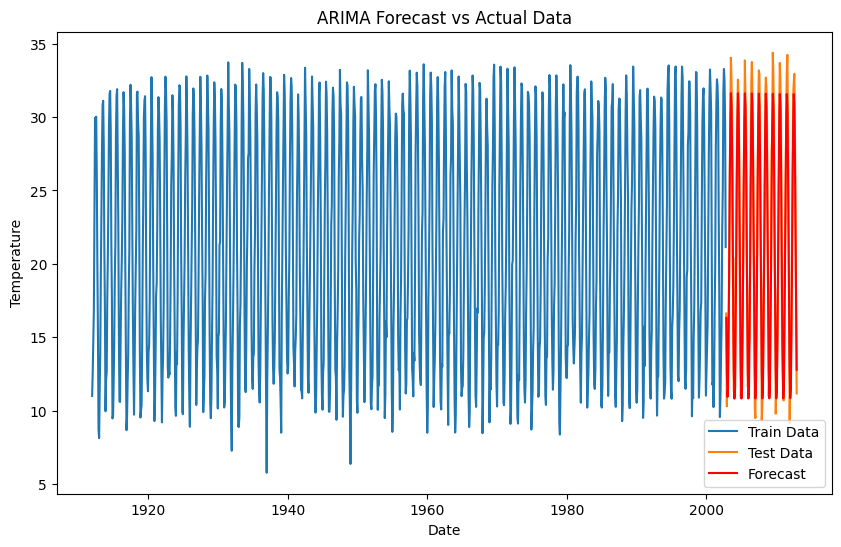

In [ ]:
forecast_steps = len(test_data)
forecast = results.forecast(steps=forecast_steps)


plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['AverageTemperature'], label='Train Data')
plt.plot(test_data.index, test_data['AverageTemperature'], label='Test Data')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('ARIMA Forecast vs Actual Data')
plt.legend()
plt.show()

In [ ]:
mae = np.mean(np.abs(forecast - test_data['AverageTemperature']))
print("\nMean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 1.4642386494489148


# The END